In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots

In [25]:
format_plots()
#format_pizza_plots()

In [26]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmf=custom_cmap

colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [27]:
## update data
def remove_crl(df):
    max=39
    syll=df.columns.values[df.columns.values>max]
    df.drop(syll,axis=1, inplace=True)
    #df.drop('b365ea6a-369f-4991-b139-15694dc1c86d',level=3, axis=0, inplace=True)
    return df[~df.index.get_level_values('session_name').str.contains('CRL')]

In [28]:
# remapped to bins
mapdr_females = {0: 3, 
       1: 5, 
       2: 7,
       3: 9,
       4: 12,
       5: 24,
       6: 36,
       7: 52,
       8: 72,
       9: 90,
       }

mapdr_males = {0: 3, 
       1: 5, 
       2: 7,
       3: 9,
       4: 12,
       5: 24,
       6: 36,
       7: 52,
       8: 78,
       9: 90,
       }

In [29]:
# arrange data
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_05/ontogeny_females_clean_v2.parquet')
f_psd = pd.read_parquet(path)
f_psd= remove_crl(f_psd)

# pseudo data males
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_05/ontogeny_males_clean_pseudotime_v02.parquet')
m_psd = pd.read_parquet(path)
m_psd=m_psd.reset_index()
m_psd=m_psd[['uuid','pseudotime_rank','age']]

#make sure only animals in clean v2 are in the male dataframe:
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_05/ontogeny_males_clean_v2.parquet')
df_males = pd.read_parquet(path)
df_males = remove_crl(df_males)
m_psd = df_males.merge(m_psd, on='uuid', how='left')

#do some cleaning up
m_psd.rename(columns={'pseudotime_rank': 'psd'}, inplace=True)
m_psd.set_index(['psd','uuid','age'], append=True, inplace=True)
m_psd = m_psd.filter(regex=r'\d')

In [30]:
# pseudo regression
from sklearn.cross_decomposition import PLSRegression
mdl = PLSRegression(n_components=3)
x = m_psd.filter(regex=r'\d')
y = x.index.get_level_values('psd')
mdl.fit(x, y)
print(mdl.score(x, y))

#if you want to log transform
#x = np.log(x + 1e-6) # convert to linear
x = f_psd.filter(regex=r'\d')
f_psd['psd']=mdl.predict(x)

0.9553095183555017


In [31]:
# to convert pseudo time into bins the lengh of the bins of cross-sectional data and remap:
# females
f_psd['bins'] = pd.qcut(f_psd['psd'], len(f_psd.index.get_level_values('age').unique()),labels=False)
y_psd=f_psd['bins'].to_numpy()
y_psd = [mapdr_females[item] for item in y_psd]
f_psd['remapped_bins'] = y_psd
f_psd.set_index(['remapped_bins','bins','psd'], append=True, inplace=True)

# males
m_psd['bins'] = pd.qcut(m_psd.index.get_level_values('psd'), len(m_psd.index.get_level_values('age').unique()),labels=False)
y_psd=m_psd['bins'].to_numpy()
y_psd = [mapdr_males[item] for item in y_psd]
m_psd['remapped_bins'] = y_psd
m_psd.set_index(['remapped_bins','bins'], append=True, inplace=True)

In [32]:
## PC both dataset together

In [33]:
#f_data = f_psd.groupby(['remapped_bins','uuid']).mean()
#m_data = m_psd.groupby(['remapped_bins','uuid']).mean()
f_data = f_psd.query('remapped_bins != 90').groupby(['remapped_bins','uuid']).mean()
m_data = m_psd.query('remapped_bins != 90').groupby(['remapped_bins','uuid']).mean()
data=pd.concat([m_data,f_data])

In [34]:
# run pca and make matrix
pcs = PCA(n_components=2).fit_transform(np.log(data + 1e-6))
pc_df = pd.DataFrame(pcs)
pc_df['psd'] = data.index.get_level_values('remapped_bins')
pc_df['sex'] = ['m'] * len(m_data) + ['f']* len(f_data)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

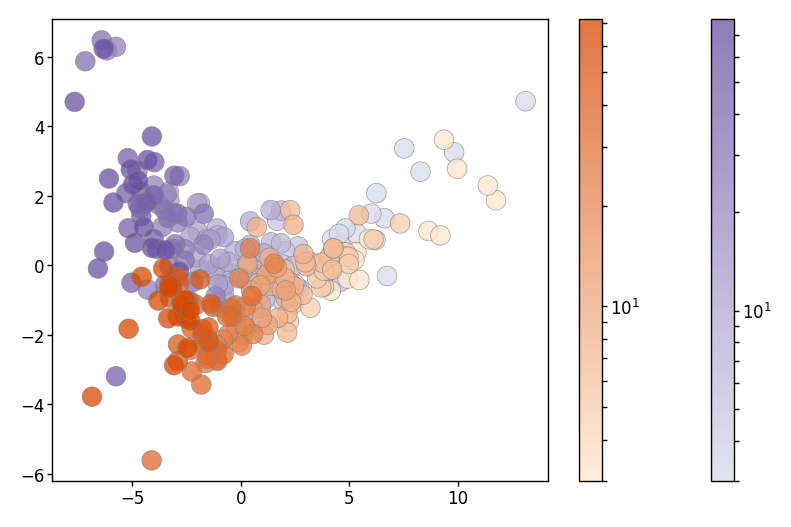

In [35]:
fig, ax = plt.subplots()
fig.set_size_inches(5,3) 
pcm = pc_df.query('sex == "m"')
pcf = pc_df.query('sex == "f"')
im = plt.scatter(x=pcm[0], y=pcm[1], 
                cmap=cmm,
                s=50,
                edgecolor='grey',
                c=pcm['psd'], 
                linewidth=0.25,
                norm='log',
            alpha=0.75,
               )
cb=fig.colorbar(im,ax=ax)
im2=plt.scatter(x=pcf[0], y=pcf[1], 
                cmap=cmf,
                s=50,
                edgecolor='grey',
                c=pcf['psd'], 
                linewidth=0.25,
                norm='log',
                alpha=0.75,
               )
cb=fig.colorbar(im2,ax=ax)
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig4_ontogeny_females"/ 'pca_fvm.pdf')

In [36]:
#PC1 correlation
from scipy import stats
[cm,pm] = stats.spearmanr(pcm[0], pcm['psd'])
print(cm)
[cf,pf] = stats.spearmanr(pcf[0], pcf['psd'])
print(cf)

-0.938271335055974
-0.9600571963961635


findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

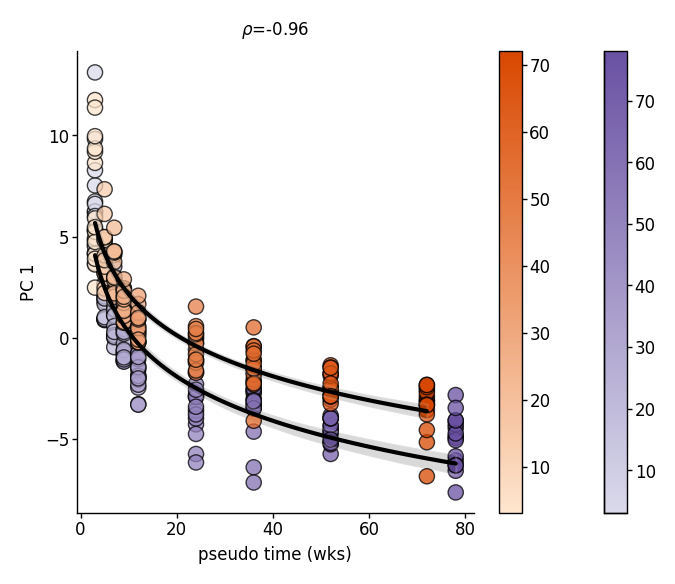

In [37]:
fig, ax = plt.subplots()
fig.set_size_inches(4,3) 
plt.scatter(x=pcm['psd'], y=pcm[0], 
            s=30, 
            c=pcm['psd'], 
            edgecolor='black',
            linewidth=0.5,
            norm='log',
            alpha=0.75,
            cmap=cmm)
ax = sns.regplot(data=pcm, x='psd', y=pcm[0], scatter=False, color='black',
                 logx=True,
                )
ax.set(xlabel='pseudo time (wks)', ylabel='PC 1')
plt.title(f'$\\rho$={cm:0.2f}')
norm = plt.Normalize(pcm['psd'].min(), pcm['psd'].max())
sns.despine()
sm = plt.cm.ScalarMappable(cmap=cmm, norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.figure.colorbar(sm)

plt.scatter(x=pcf['psd'], y=pcf[0], 
            s=30, 
            c=pcf['psd'], 
            edgecolor='black',
            linewidth=0.5,
            alpha=0.75,
            norm='log',
            cmap=cmf)
ax = sns.regplot(data=pcf, x='psd', y=pcf[0], scatter=False, color='black',
                 logx=True,
                )
ax.set(xlabel='pseudo time (wks)', ylabel='PC 1')
plt.title(f'$\\rho$={cf:0.2f}')
norm = plt.Normalize(pcf['psd'].min(), pcf['psd'].max())
sns.despine()
sm = plt.cm.ScalarMappable(cmap=cmf, norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.figure.colorbar(sm)


c = PlotConfig()
fig.savefig(c.dana_save_path / "fig4_ontogeny_females"/ 'pca_corr_fvm.pdf')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

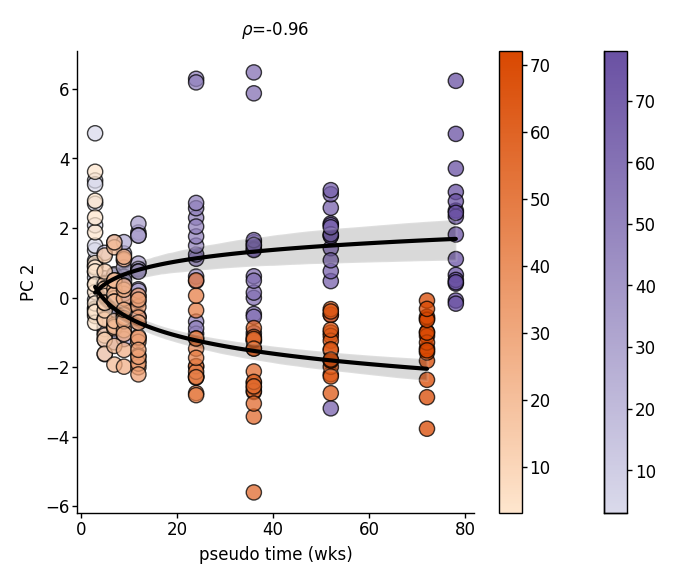

In [38]:
fig, ax = plt.subplots()
fig.set_size_inches(4,3) 
plt.scatter(x=pcm['psd'], y=pcm[1], 
            s=30, 
            c=pcm['psd'], 
            edgecolor='black',
            linewidth=0.5,
            norm='log',
            alpha=0.75,
            cmap=cmm)
ax = sns.regplot(data=pcm, x='psd', y=pcm[1], scatter=False, color='black',
                 logx=True,
                )
ax.set(xlabel='pseudo time (wks)', ylabel='PC 2')
plt.title(f'$\\rho$={cm:0.2f}')
norm = plt.Normalize(pcm['psd'].min(), pcm['psd'].max())
sns.despine()
sm = plt.cm.ScalarMappable(cmap=cmm, norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.figure.colorbar(sm)

plt.scatter(x=pcf['psd'], y=pcf[1], 
            s=30, 
            c=pcf['psd'], 
            edgecolor='black',
            linewidth=0.5,
            alpha=0.75,
            norm='log',
            cmap=cmf)
ax = sns.regplot(data=pcf, x='psd', y=pcf[1], scatter=False, color='black',
                 logx=True,
                )
ax.set(xlabel='pseudo time (wks)', ylabel='PC 2')
plt.title(f'$\\rho$={cf:0.2f}')
norm = plt.Normalize(pcf['psd'].min(), pcf['psd'].max())
sns.despine()
sm = plt.cm.ScalarMappable(cmap=cmf, norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.figure.colorbar(sm)


c = PlotConfig()
fig.savefig(c.dana_save_path / "fig4_ontogeny_females"/ 'pc2_corr_fvm.pdf')

In [39]:
from scipy.stats import linregress
mslope, mintercept, mr_value, mp_value, mslope_std_error = linregress(np.log(pcm['psd']), pcm[0])
fslope, fintercept, fr_value, fp_value, fslope_std_error = linregress(np.log(pcf['psd']), pcf[0])

In [40]:
mslope

-3.160845049037082

In [41]:
mr_value

-0.8908099211723425

In [42]:
fslope

-2.92644500994283

In [43]:
fr_value

-0.9083659178566004

In [44]:
import math
t = (mslope - fslope) / math.sqrt(mslope_std_error**2 + fslope_std_error**2)

In [45]:
t

-1.3210680005601751

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

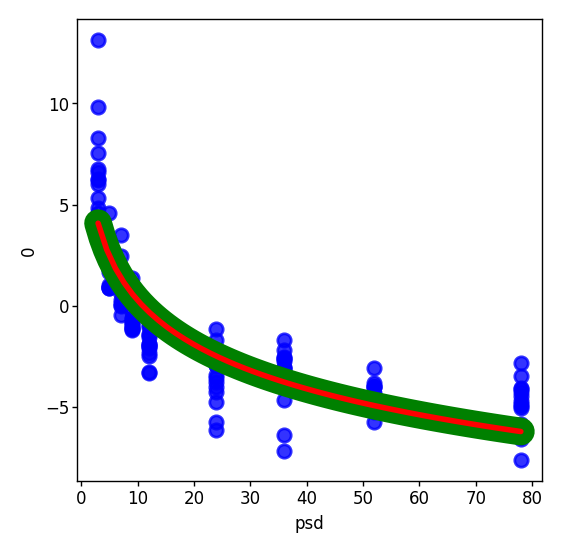

In [46]:
x=pcm['psd']
y=pcm[0]
ax = sns.regplot(x=x, y=y, color='blue',logx=True, line_kws=dict(color="g", lw=10))

fit = stats.linregress(np.log(x), y)
slope, intercept, r_value, p_value, slope_std_error = linregress(np.log(x), y)

grid = np.linspace(x.min(), x.max())
ax.plot(grid, fit.intercept + fit.slope * np.log(grid), color="r", lw=2)